In [1]:
suppressMessages(library(tidyverse))
library(ggrepel)

In [2]:
df <- readr::read_tsv("data/Stats.TECAN.AL002_vs_isotype.txt")

Rows: 13891 Columns: 9
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): geneID, gene
dbl (7): baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, PercentDetecte...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
df <- df[df$PercentDetectedSamples > 0.9,]

In [4]:
# Add a new column to identify significant genes
df$Significant <- ifelse((df$padj < 0.1) & (abs(df$log2FoldChange) > 0), "red", "black")

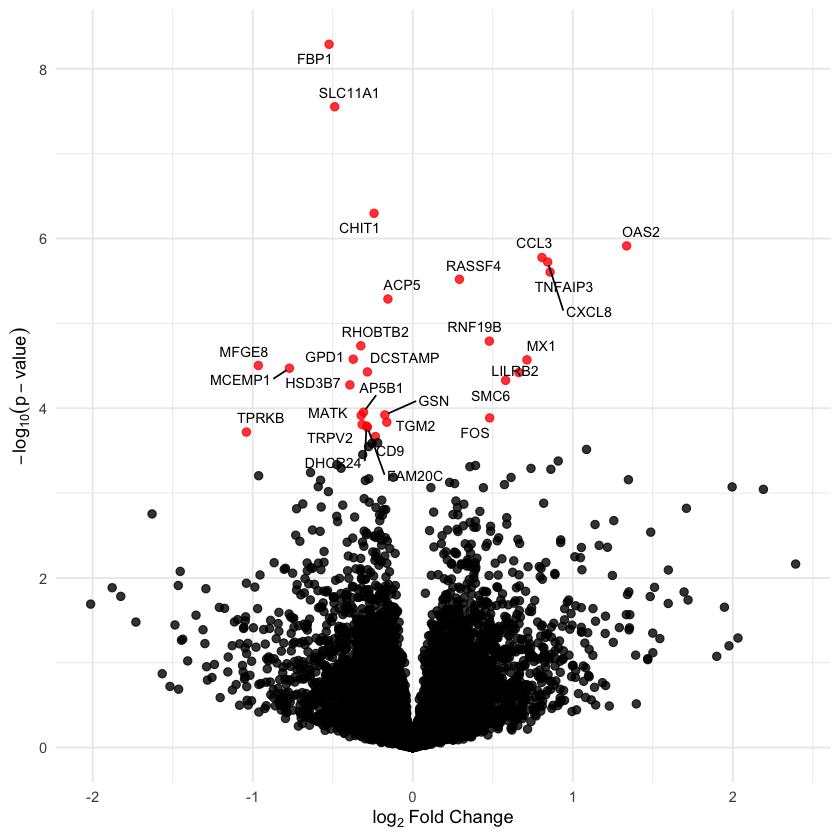

In [6]:
# Create the volcano plot with -log10(padj)
fig <- ggplot(df, aes(x = log2FoldChange, y = -log10(pvalue))) +
  geom_point(aes(color = Significant), alpha = 0.8, size = 2) +  # Add points with color based on significance
  scale_color_manual(values = c("red" = "red", "black" = "black")) +  # Set color manually
  geom_text_repel(
    data = subset(df, (padj < 0.1) & abs(log2FoldChange) > 0), 
    aes(label = gene), 
    size = 3, 
    box.padding = 0.3, 
    point.padding = 0.2,
    max.overlaps = Inf
  ) +  # Add gene names to significant points
  theme_minimal() +  # Use a minimal theme
  labs(
    x = expression(log[2]~"Fold Change"), 
    y = expression(-log[10](p-value)), 
  ) +  # Label axes and title
  theme(
    legend.position = "none"
  )  # Remove legend

fig

In [7]:
ggsave(fig, file="figures/fig4a.pdf", width=5, height=5)

## Figure 4B-D

In [8]:
kegg <- readr::read_tsv("outputs/KEGG_AL002.tsv") |> dplyr::select(c(set_descr, p_val, p_adj, foldEnrich))
no_context <- readr::read_tsv("outputs/no_context_AL002.tsv") |> dplyr::select(c(set_descr, p_val, p_adj, foldEnrich))
context <- readr::read_tsv("outputs/with_context_AL002.tsv")  |> dplyr::select(c(set_descr, p_val, p_adj, foldEnrich))

Rows: 320 Columns: 12
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): set_descr, intersection, set_genes
dbl (9): generatio, bgratio, richFactor, foldEnrich, p_val, p_adj, ngenes, n...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 94 Columns: 14
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (3): set_descr, intersection, set_genes
dbl (11): generatio, bgratio, richFactor, foldEnrich, p_val, p_adj, ngenes, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 95 Columns: 14
── Column specification ─

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”


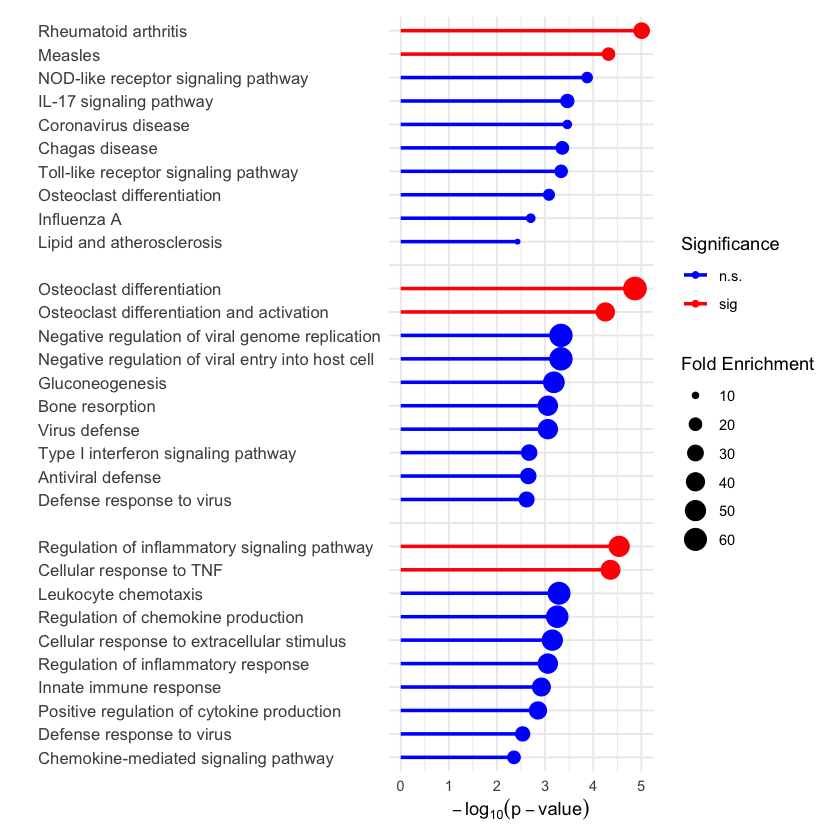

In [9]:
df <- rbind(rbind(kegg[1:10,], NA),
            rbind(no_context[1:10,], NA), 
            rbind(context[1:10,], NA))
df$p_adj[is.na(df$set_descr)] <- 1
df$set_descr[is.na(df$set_descr)] <- ""


# Add a space after repeated strings in set_descr
df$set_descr <- ave(df$set_descr, df$set_descr, FUN = function(x) {
  if (length(x) > 1) {
    paste0(x, c("", rep(" ", length(x) - 1)))
  } else {
    x
  }
})


df <- df %>%
  mutate(
    log_p_val = -log10(p_val),
    significance = ifelse(p_adj < 0.01, "sig", "n.s."),
      set_descr = factor(set_descr, levels = rev(unique(set_descr)))
      )

# Create the lollipop plot
fig <- ggplot(df, aes(x = log_p_val, y = set_descr, color =significance)) +
  geom_segment(aes(x = 0, xend = log_p_val, y = set_descr, yend = set_descr), size = 1) +
  geom_point(aes(size = foldEnrich)) +
  scale_color_manual(values = c("sig" = "red", "n.s." = "blue")) +
  scale_size_continuous() +
  labs(x = expression(-log[10](p-value)), y = "", color = "Significance", size = "Fold Enrichment") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 10, hjust = 0),  # Right-justify y-axis text
    plot.margin = margin(t = 10, r = 10, b = 10, l = 10)  # Adjust margins as needed
  ) 
fig


In [28]:
ggsave(fig, file="figures/fig4b.pdf", width=7, height=6)

Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_segment()`).”
Warning message:
“Removed 3 rows containing missing values or values outside the scale range (`geom_point()`).”
